# ECG Arrhythmia detection

This project aims to demonstrate the Anomaly Detection module implemented in Darts
### Dataset
The MIT-BIH Supraventricular Arrhythmia Database (SVDB) contains 2 channels, and 78 half-hour ECG recordings obtained from 47 objects between 1975-1979.

### Task
Develop an anomaly detection model to identity arrhythmia in the ECG signal.

## Downloading ECG dataset

In [ ]:
# Download data from data source to a local holder
import io
import os
import zipfile
import requests

# URL of the zip file
zip_url = "https://my.hidrive.com/api/sharelink/download?id=lmCmAjUP"

# Folder path to save the downloaded zip file
folder_path = "dataset"

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Send a GET request to download the zip file
response = requests.get(zip_url)

# Check if the request was successful
if response.status_code == 200:
    # File path to save the downloaded zip file
    file_path = os.path.join(folder_path, "svdb.zip")

    # Save the zip file to the local drive
    with open(file_path, "wb") as file:
        file.write(response.content)
    print("Zip file downloaded successfully.")

    # Extract the zip file
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(folder_path)
    print("Zip file extracted successfully.")
else:
    print("Failed to download the zip file.")

## Install required libaries for anomaly detection

In [ ]:
# Install the library darts
!git clone https://github.com/unit8co/darts.git
!pip install darts/. -q

## Task #1
Load data of a patient into a darts timeseries object

In [1]:
patient_number = '842'

In [2]:
from darts import TimeSeries

# Load data into darts TimeSeries object
timeseries = TimeSeries.from_csv(f"./dataset/multivariate/SVDB/{patient_number}.test.csv", time_col='timestamp')
ts_ecg = timeseries[['ECG1','ECG2']]
ts_anomaly = timeseries['is_anomaly']

### Visualize signal and anomaly

<Axes: xlabel='timestamp'>

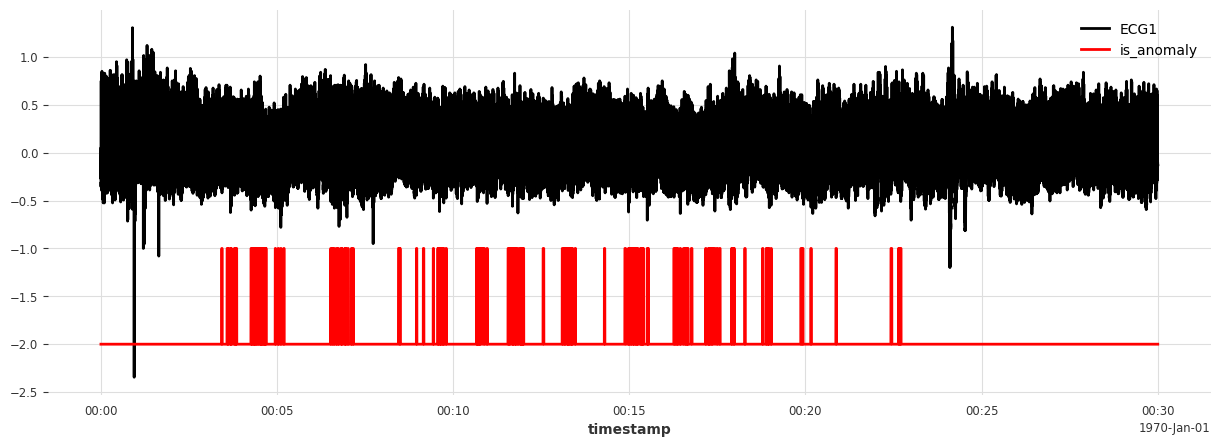

In [3]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1, figsize=(15,5))
ts_ecg['ECG1'].plot(ax=ax,label='ECG1')
(ts_anomaly-2).plot(ax=ax,label='is_anomaly',color='r')

## Task #2
Identify a region of ~15000 datapoints with anomalies (Otherwise training takes for a while) and visualize it

In [4]:
# Identify a subset for demonstration
shift = 15000
start = 0
end = 15000
ts_ecg_subset= ts_ecg[start+shift:end+shift]
ts_anomaly_subset = ts_anomaly[start+shift:end+shift]

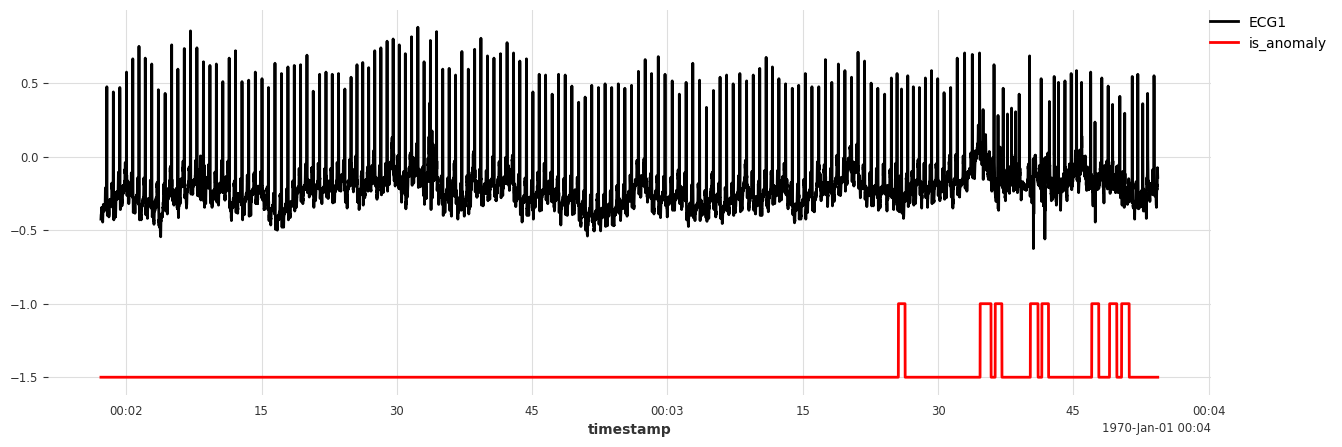

In [5]:
# Visualize the subset
fig,ax = plt.subplots(1,1, figsize=(15,5))
ts_ecg_subset['ECG1'].plot(ax=ax,label='ECG1')
((ts_anomaly_subset/2)-1.5).plot(ax=ax,label='is_anomaly',color='r')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper center', borderaxespad=0)

## Task #3
Create training and test set size (e.g., 10k/5k, 12k/2k datapoints)

In [6]:
# Create train and test dataset for demonstration
split = 10000
ts_ecg_train = ts_ecg_subset[:split]
ts_ecg_test = ts_ecg_subset[split:15000]
ts_anomaly_test = ts_anomaly_subset[split:15000]

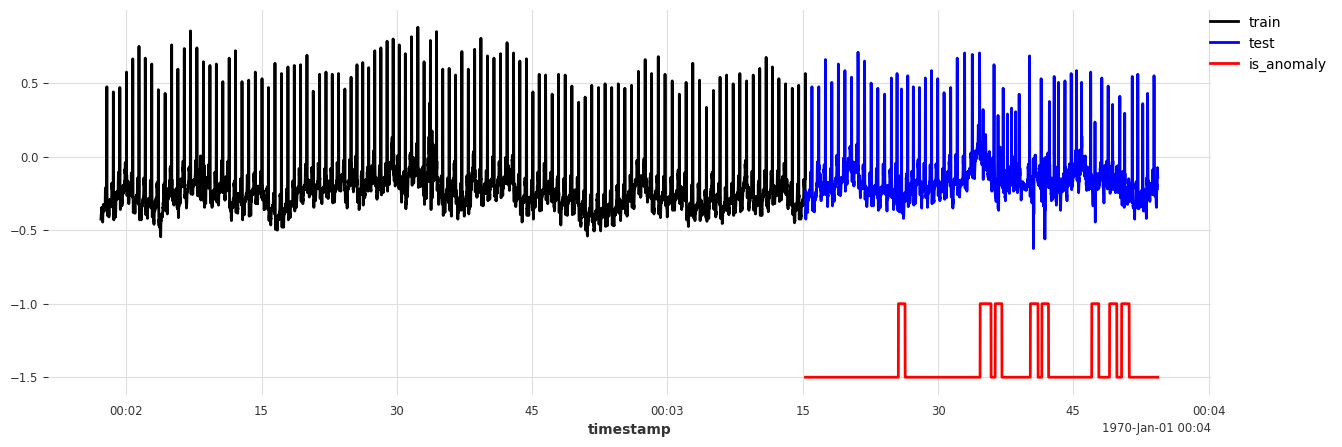

In [7]:
# Visualize the train / test set as well as the test set anomalies
fig,ax = plt.subplots(1,1, figsize=(15,5))
ts_ecg_train['ECG1'].plot(ax=ax,label='train')
ts_ecg_test['ECG1'].plot(ax=ax,color='b', label='test')
((ts_anomaly_test/2)-1.5).plot(ax=ax,label='is_anomaly',color='r')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper center', borderaxespad=0)

## Task #4
Assess data properties such as periodicity and identify most common period.

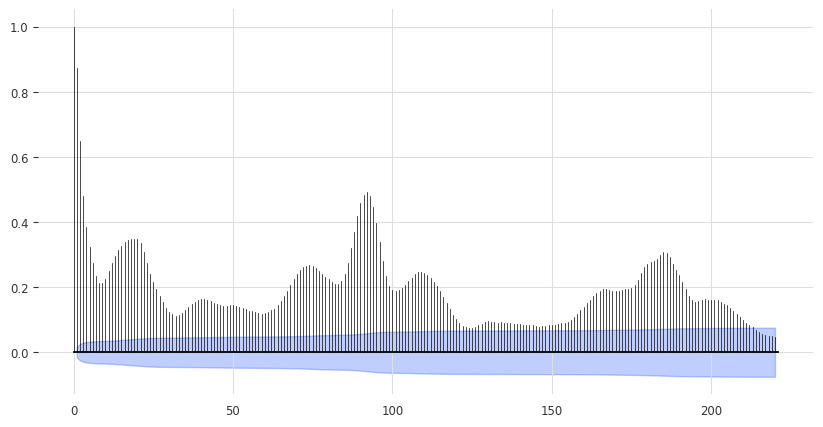

In [8]:
from darts.utils.statistics import plot_acf

# Visualise signal auto correlation to identify most common periodicity
plot_acf(ts=ts_ecg_subset['ECG1'], max_lag=220)
plt.show()

In [9]:
# Identified most common period
period = 90

## Task #5
Develop an anomaly detection model step by step by (see figure below):
1. Creating a forecasting model based on the train timeseries ECG data
2. Create historical forecasting for the test timeseries ECG data
3. Create anomaly scores using 2 different scores based on the forecasted and actual ECG signal

<img src="images/ad_inside_anomaly_model.png" alt="Image" width="60%" height="60%">

Links:
- Forecasting models: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.html
- Scorers: https://unit8co.github.io/darts/generated_api/darts.ad.scorers.html?highlight=scorer#

### Create a Forecasting model

In [10]:
from darts.models import LinearRegressionModel

# Instatiate of a forecasting model - e.g. RegressionModel with a defined lag
forecasting_model = LinearRegressionModel(lags=period)

# Train the forecasting model on the training dataset
forecasting_model.fit(ts_ecg_train)

/Users/aronhorvath/Documents/u8/bd/sds/sds2024-anomaly-detection/env/lib/python3.9/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


LinearRegressionModel(lags=90, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

<Axes: xlabel='time'>

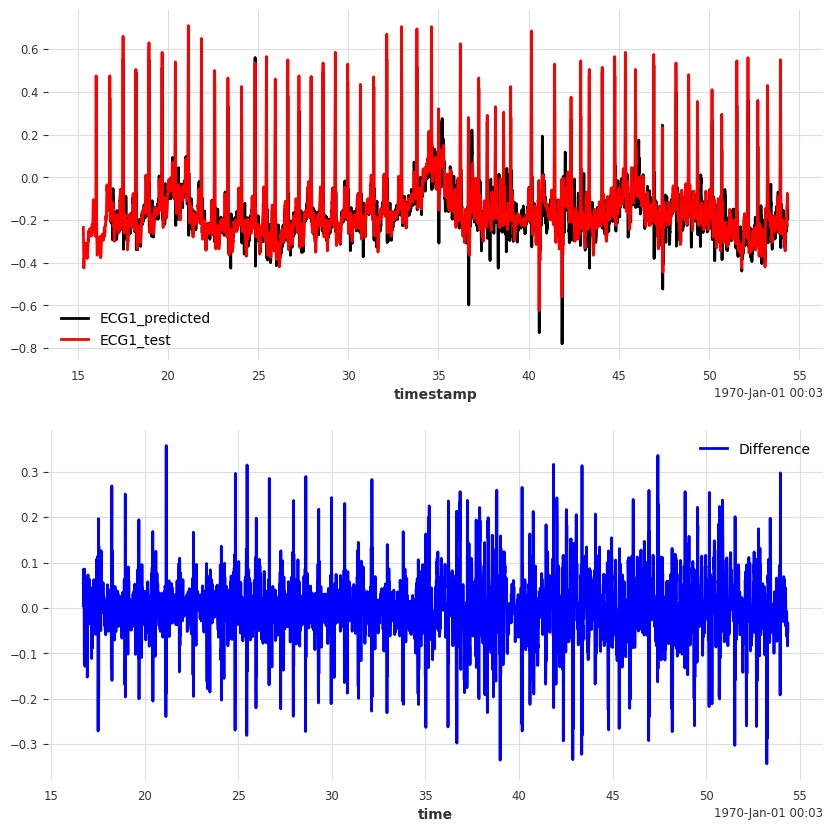

In [11]:
# Visualization of predicted and actual signal
fig,ax = plt.subplots(2,1,figsize=(10,10))
START = 2 * period
ts_ecg_predicted = forecasting_model.historical_forecasts(ts_ecg_test,retrain=False, start=START)
ts_ecg_predicted['ECG1'].plot(ax=ax[0],label='ECG1_predicted')
ts_ecg_test['ECG1'].plot(ax=ax[0],color='r',label='ECG1_test')

# Residual
(ts_ecg_predicted-ts_ecg_test[START:])['ECG1'].plot(ax=ax[1], color='b',label='Difference')

### Use a NormScorer for scoring.

In [12]:
from darts.ad.scorers import NormScorer
scorer = NormScorer(ord=1, component_wise=False)

<Axes: xlabel='timestamp'>

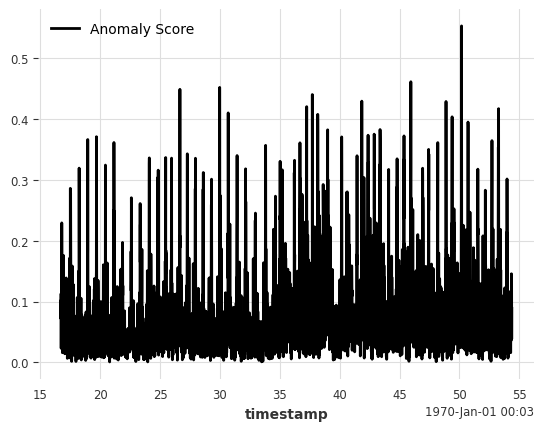

In [13]:
# Calculate anomaly scores by taking the pointwise norm 1 (L1) and visualize the score
scores =  scorer.score_from_prediction(ts_ecg_test, ts_ecg_predicted)
scores.plot(label='Anomaly Score')

In [14]:
# Evaluate the calculated anomaly score using utility methods in darts
from darts.ad.utils import eval_metric_from_scores
eval_metric_from_scores(pred_scores=scores,window=1, anomalies=ts_anomaly_test, metric='AUC_ROC')

0.6241111698379141

### Use KMeansScorer for scoring:
Norm scorer point wise calculates the norm between the predicted and actual timeseries. Since predicting th peak of the ECG signals are challenging for the model - the biggest differences can between the actual and predicted values are mostly found at the peak locations.

To overcome this issue stemming from the point wise comparison, a windowing approach inherent in the KMeanScorer will be used.
The KMeanScorer is a trainable scorer - meaning -  on the anomaly free dataset it fits 'k' centroids on the vectors/chunks of the ECG signal created by using a sliding window with width of 'w'. The scoring is done by determining the closest centroid distance to any future ECG window with the same size 'w'. Since the training was done on anomaly free windows, those windows which are containing anomalies will have larger distances even from the closest centroid.

The KMeanScorer as the figure illustrates below can directly used on the timeseries itself, however we will use the previously developed forecasting model to create historical prediction for the train dataset and do the training of the KMeanScorer on the absoule difference of the actual training and forecasted training dataset.

#### Training & Scoring
<img src="images/kmeansscorer.png" alt="Image" width="70%" height="70%">

<img src="images/ad_windowing.png" alt="Image" width="70%" height="70%">

In [15]:
from darts.ad.scorers import KMeansScorer
scorer = KMeansScorer(k=50, window=2*period, component_wise=False)

In [16]:
# Create historical forecasting on the trianing dataset for the scorer to be able to train
ts_ecg_train_predicted = forecasting_model.historical_forecasts(ts_ecg_train, retrain=False, start=START)

In [17]:
scorer.fit_from_prediction(ts_ecg_train,ts_ecg_train_predicted) 

/Users/aronhorvath/Documents/u8/bd/sds/sds2024-anomaly-detection/env/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


#### Remark

The function diff_fn passed as a parameter to the scorer, will transform pred_series and actual_series into one series. By default, diff_fn will compute the absolute difference (Default: “abs_diff”). If pred_series and actual_series are sequences, diff_fn will be applied to all pairwise elements of the sequences.


In [18]:
# Create forecasting data for the test dataset
ts_ecg_test_predicted = forecasting_model.historical_forecasts(ts_ecg_test, retrain=False, start=START)

<Axes: xlabel='time'>

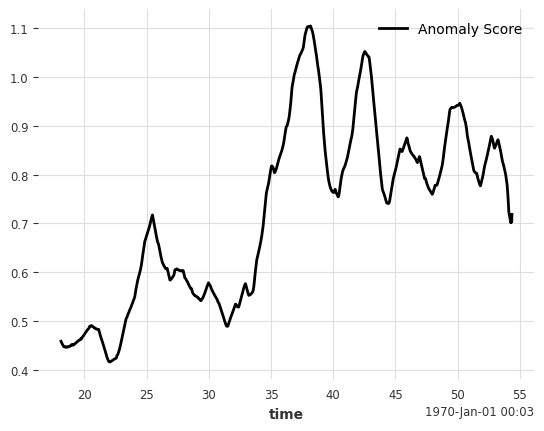

In [19]:
# Use the trained scorer on the forecasted and actual test dataset
scores = scorer.score_from_prediction(ts_ecg_test,ts_ecg_test_predicted)
scores.plot(label='Anomaly Score')

In [20]:
# Calculate the performance on the scorer using built-in utils methods in darts
from darts.ad.utils import eval_metric_from_scores
eval_metric_from_scores(pred_scores=scores,window=2*period, anomalies=ts_anomaly_test, metric='AUC_ROC')

0.8474886938984436

## Task #6
Now use the Forecasting Anomaly Model via dedicated Darts API interface
This exercise aims to illustrate the power of the darts anomaly detection module by hiding all of the previously made steps under the hood into one dedicated AnomalyModel and corresponding APIs

In [21]:
from darts.ad.anomaly_model.forecasting_am import ForecastingAnomalyModel
from darts.models import LinearRegressionModel
from darts.ad.scorers import NormScorer, KMeansScorer

# Instatiate of a forecasting model - e.g. RegressionModel with a defined lag
forecasting_model = LinearRegressionModel(lags=period)

# Instantiate the anomaly model with: one forecasting model, and one or more scorers (and corresponding parameters)
anomaly_model = ForecastingAnomalyModel(
    model=forecasting_model,
    scorer=[
         NormScorer(ord=1),
         KMeansScorer(k=50, window=2*period, component_wise=False)
    ],
)

# Fit anomaly model
START = 2 * period
anomaly_model.fit(ts_ecg_train, start=START, allow_model_training=True)

### Create anomaly scores and prediction in one step


In [22]:
# Score with the anomaly model (forecasting + scoring)
anomaly_scores, model_forecasting = anomaly_model.score(
    ts_ecg_test, start=2*period, return_model_prediction=True
)


### Visualize the forecasted signal as well as the anomalies

<Axes: xlabel='time'>

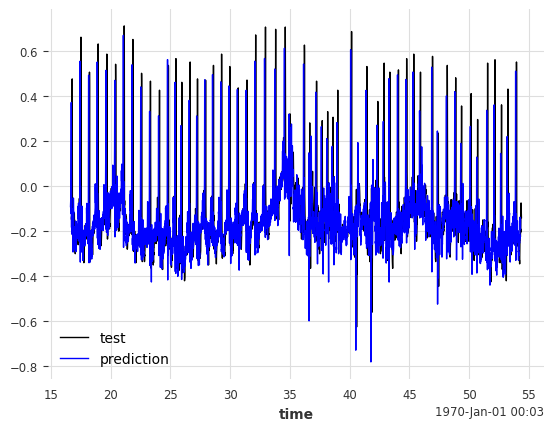

In [23]:
# Forecasting
fig, ax = plt.subplots(1,1)
window = 10000
ts_ecg_test['ECG1'][2*period:2*period+window].plot(ax=ax,color='k',linewidth=1,label='test')
model_forecasting['ECG1'][:window].shift(-10).plot(ax=ax,color='b',linewidth=1,label='prediction')

<Axes: xlabel='timestamp'>

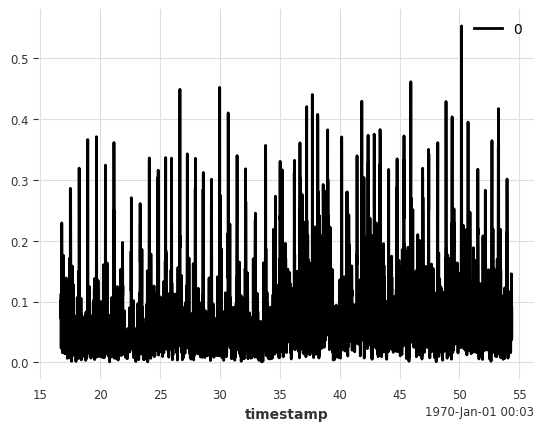

In [25]:
# Anomalies
anomaly_scores[0].plot() # indeces corresponding to the scorers

### Leverage the inbuilt darts visualization tool to evaluate and show anomalies

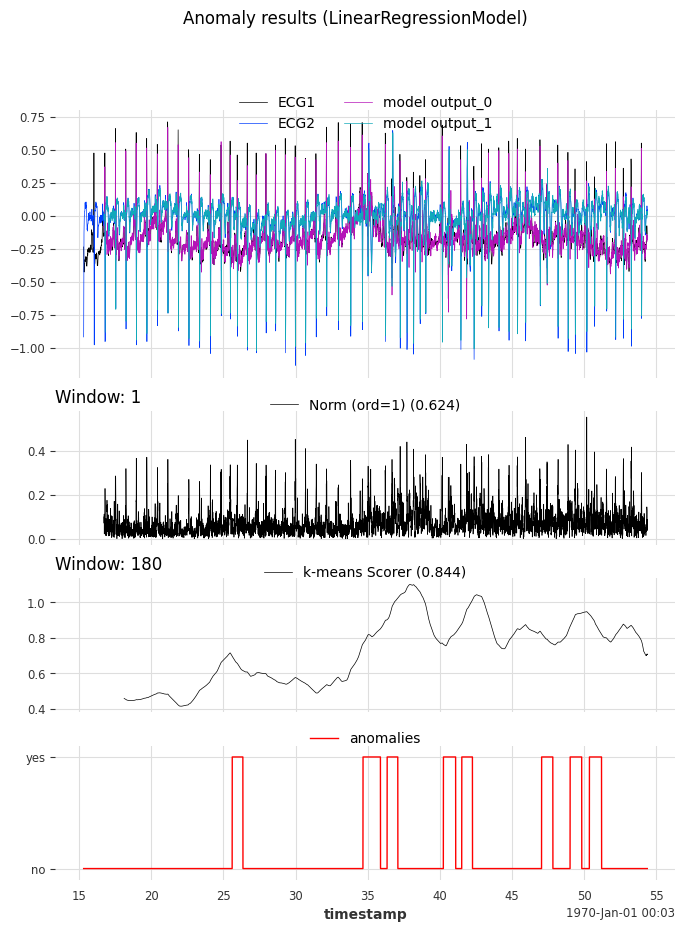

In [26]:
# Visualize and evalute detection of anomalies
anomaly_model.show_anomalies(
    series=ts_ecg_test,
    anomalies=ts_anomaly_test,
    start=START,
    metric="AUC_ROC",
)
#plt.show()

## Task #7
Use a detector to binarize the anomaly scores

Link:
- https://unit8co.github.io/darts/generated_api/darts.ad.detectors.html?highlight=detector

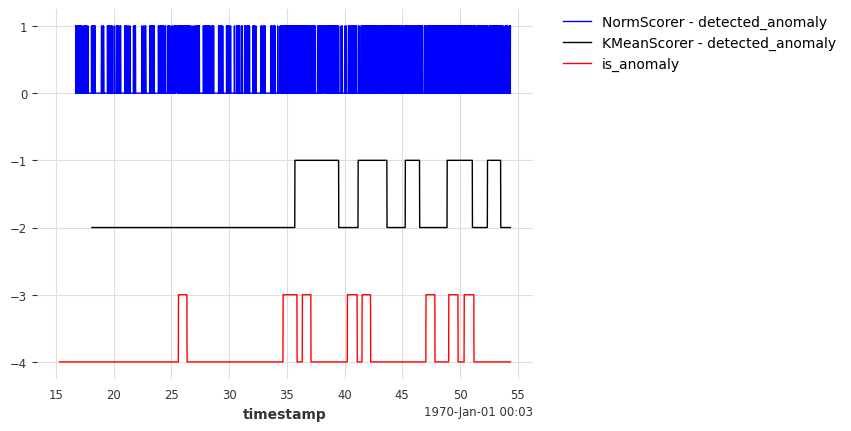

In [27]:
from darts.ad.detectors import QuantileDetector,ThresholdDetector

# Instantiate a detector
detector =  QuantileDetector(0,0.70)

fig, ax = plt.subplots(1,1)
(detector.fit_detect(anomaly_scores[0])-0).plot(ax=ax, color='b',linewidth=1,label='NormScorer - detected_anomaly')
(detector.fit_detect(anomaly_scores[1])-2).plot(ax=ax, color='k',linewidth=1,label='KMeanScorer - detected_anomaly')
(ts_anomaly_test-4).plot(ax=ax, color='r',linewidth=1,label='is_anomaly')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

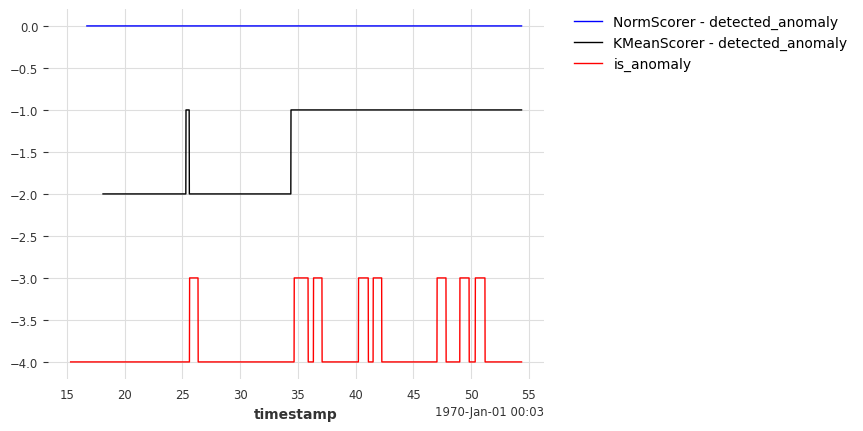

In [28]:
from darts.ad.detectors import ThresholdDetector

# Instantiate a detector
detector =  ThresholdDetector(0, 0.7)

fig, ax = plt.subplots(1,1)
(detector.detect(anomaly_scores[0])-0).plot(ax=ax, color='b',linewidth=1,label='NormScorer - detected_anomaly')
(detector.detect(anomaly_scores[1])-2).plot(ax=ax, color='k',linewidth=1,label='KMeanScorer - detected_anomaly')
(ts_anomaly_test-4).plot(ax=ax, color='r',linewidth=1,label='is_anomaly')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)